In [2]:
%load_ext tensorboard

In [107]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('/home/yp/workspace/hdd0/tfboard')

In [ ]:
# images
img_batch = np.zeros((16, 3, 100, 100))
writer.add_images('group/name', img_batch, step)

In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import argparse

parser = argparse.ArgumentParser("Train code")   
# for jupyter
parser.add_argument('-f',help="batch size ")
# setting
parser.add_argument('-m'  ,'--mode'   ,default=-1, type =int  ,metavar='{...}'    ,help="mode index 0: 'edsr','espcn','fsrcnn','lapsrn','bilinear','bicubic'] ")
parser.add_argument('-b'  ,'--batch'   ,default=-1, type =int  ,metavar='{...}'    ,help="batch size ")
args = parser.parse_args()

def get_idle_gpu():
    import GPUtil as gp
    gpus = gp.getGPUs()
    gpus_util = [gpu.memoryUtil for gpu in gpus]
    
    import numpy as np
    index = np.argmin(gpus_util)
    device = 'cuda:'+str(index)
    return device

device = get_idle_gpu()
device = 'cuda:0'
num_epochs = 20
batch_size = args.batch if args.batch != -1 else 4
pretrained = False

mode_names = ['edsr','espcn','fsrcnn','lapsrn','bilinear','bicubic']
mode_index = args.mode if args.mode != -1 else 1
mode_index = 4  
mode_name = 'ensemble-'+ mode_names[mode_index] if mode_index in range(0,4) else mode_names[mode_index]

classes = ['Nothing','Pedestrian']    

print(f'{mode_name} is started on the {device}')
print(f'batch {batch_size}')

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"]    = boxes
        target["labels"]   = labels
        target["masks"]    = masks
        target["image_id"] = image_id
        target["area"]     = area
        target["iscrowd"]  = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from rcnn_transfrom import InterpolationTransform as it
      
def get_instance_segmentation_model(num_classes,pretrained=True,mode_name='ensemble-edsr'):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    
    model.transform = it(min_size=(800,), max_size=1333,image_mean=[0.485, 0.456, 0.406],image_std=[0.229, 0.224, 0.225],mode=mode_name)
    return model

from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

dataset      = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)


bilinear is started on the cuda:0
batch 4


In [2]:
num_classes = 2

model = get_instance_segmentation_model(num_classes,pretrained=pretrained,mode_name=mode_name)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

def tfboard_loss(writer,logger,epoch,mbatch=10):

    unit = logger.meters['loss'].count //mbatch
    metrics = ['loss', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg']
    
    for i in range(unit):
        x = epoch*unit + i+1
        for name in metrics :
            values = list(logger.meters[name].deque)[i*mbatch:(i+1)*mbatch]
            mean   = np.mean(values)
            writer.add_scalar(f'mrcnn-{mode_name}-b{batch_size}-p{pretrained}/{name}',mean,x)
def tfboard_pr_curve():
    pass
from torch.utils.tensorboard import SummaryWriter
tfboard_dir = '/home/yp/workspace/hdd0/tfboard'
writer = SummaryWriter(tfboard_dir)

from tqdm import notebook as nb
import tqdm
evaluators = []
for epoch in range(num_epochs):
    
    logger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
#     tfboard_loss(writer,logger,epoch,mbatch=10)

    lr_scheduler.step()
    # evaluate on the test dataset
    # device = 'cuda:1'
    # model.to(device)
    evaluators.append( evaluate(model, data_loader_test, device=device) )
    # pr_curve
    break
    tfboard_pr_curve(evaluators[epoch])
    # add_figure

writer.close()

/home/yp/anaconda3/envs/tor1.9/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [ 0/30]  eta: 0:00:21  lr: 0.000177  loss: 3.5553 (3.5553)  loss_classifier: 0.6631 (0.6631)  loss_box_reg: 0.0116 (0.0116)  loss_mask: 2.1664 (2.1664)  loss_objectness: 0.6944 (0.6944)  loss_rpn_box_reg: 0.0198 (0.0198)  time: 0.7304  data: 0.2573  max mem: 4514
Epoch: [0]  [10/30]  eta: 0:00:10  lr: 0.001900  loss: 2.6901 (2.7042)  loss_classifier: 0.6170 (0.6005)  loss_box_reg: 0.0063 (0.0073)  loss_mask: 1.3600 (1.3883)  loss_objectness: 0.6906 (0.6903)  loss_rpn_box_reg: 0.0166 (0.0177)  time: 0.5075  data: 0.0317  max mem: 6102
Epoch: [0]  [20/30]  eta: 0:00:04  lr: 0.003622  loss: 1.9074 (2.1889)  loss_classifier: 0.4608 (0.4083)  loss_box_reg: 0.0116 (0.0329)  loss_mask: 0.7506 (1.0716)  loss_objectness: 0.6837 (0.6565)  loss_rpn_box_reg: 0.0171 (0.0195)  time: 0.4848  data: 0.0198  max mem: 6102
Epoch: [0]  [29/30]  eta: 0:00:00  lr: 0.005000  loss: 1.6714 (1.9026)  loss_classifier: 0.1945 (0.3179)  loss_box_reg: 0.0387 (0.0536)  loss_mask: 0.7083 (0.9580)  loss_ob

### evaluator for pr curve 

In [4]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('/home/yp/workspace/hdd0/tfboard')

In [9]:
# goal
# labels      = [0, 1, 1, 1, 1, 0, 1, 1, ...]
# predictions = [0.56992057, 0.62603284, 0.65545216, 0.26246041, ...]
writer.add_pr_curve('pr_curve', labels, predictions, 0)

In [6]:
import numpy as np
labels = np.random.randint(2, size=100)  # binary label
predictions = np.random.rand(100)

In [4]:
# save
import pickle
with open("evaluators[0].pickle","wb") as fw:
    pickle.dump(evaluators[0], fw)

In [3]:
# load 
import pickle
with open("evaluators[0].pickle","rb") as fr:
    evt = pickle.load(fr)

In [17]:
evt.coco_eval['bbox'].stats

array([ 7.21188884e-03,  3.80989466e-02,  5.20755682e-04, -1.00000000e+00,
        0.00000000e+00,  7.77728481e-03,  0.00000000e+00,  8.31932773e-02,
        2.12605042e-01, -1.00000000e+00,  0.00000000e+00,  2.27927928e-01])

In [19]:
evt.summarize()

IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.228
IoU metric: segm
 Ave

In [51]:
dir(evaluators[0].coco_eval['bbox'].cocoDt

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'annToMask',
 'annToRLE',
 'anns',
 'catToImgs',
 'cats',
 'createIndex',
 'dataset',
 'download',
 'getAnnIds',
 'getCatIds',
 'getImgIds',
 'imgToAnns',
 'imgs',
 'info',
 'loadAnns',
 'loadCats',
 'loadImgs',
 'loadNumpyAnnotations',
 'loadRes',
 'showAnns']

In [56]:
len(evaluators[0].coco_eval['bbox'].cocoDt.anns)

14

In [57]:
len(evaluators[0].coco_eval['bbox'].cocoGt.anns)

423

In [ ]:
evaluators[0].coco_gt

In [30]:
evaluators[0].coco_eval['bbox']

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_dts',
 '_gts',
 '_paramsEval',
 '_prepare',
 'accumulate',
 'cocoDt',
 'cocoGt',
 'computeIoU',
 'computeOks',
 'eval',
 'evalImgs',
 'evaluate',
 'evaluateImg',
 'ious',
 'params',
 'stats',
 'summarize']

In [36]:
evaluators[0].coco_eval['bbox'].cocoDt.anns

{1: {'image_id': 97,
  'category_id': 1,
  'bbox': [38.95486831665039,
   230.05743408203125,
   333.16351318359375,
   153.94256591796875],
  'score': 0.19475308060646057,
  'segmentation': [[38.95486831665039,
    230.05743408203125,
    38.95486831665039,
    384.0,
    372.11838150024414,
    384.0,
    372.11838150024414,
    230.05743408203125]],
  'area': 51288.04608972743,
  'id': 1,
  'iscrowd': 0},
 2: {'image_id': 97,
  'category_id': 1,
  'bbox': [173.01646423339844,
   186.96368408203125,
   231.3203582763672,
   197.03631591796875],
  'score': 0.19121640920639038,
  'segmentation': [[173.01646423339844,
    186.96368408203125,
    173.01646423339844,
    384.0,
    404.3368225097656,
    384.0,
    404.3368225097656,
    186.96368408203125]],
  'area': 45578.5111916,
  'id': 2,
  'iscrowd': 0},
 3: {'image_id': 97,
  'category_id': 1,
  'bbox': [3.2690014839172363,
   185.065185546875,
   237.44052124023438,
   198.934814453125],
  'score': 0.18560369312763214,
  'segment

In [27]:
evaluators[0].coco_gt.anns.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [3]:
evaluators[0]

In [22]:
# images ✔
# evaluation( loss) ✔
# pr_curve 
# weights over epoch

In [18]:
# images (in unit of batch size)
def max_by_axis( the_list):
    # type: (List[List[int]]) -> List[int]
    maxes = the_list[0]
    for sublist in the_list[1:]:
        for index, item in enumerate(sublist):
            maxes[index] = max(maxes[index], item)
    return maxes

def batch_images(images):
    # type: (List[Tensor], int) -> Tensor

    max_size = max_by_axis([list(img.shape) for img in images])
    batch_shape = [len(images)] + max_size
    batched_imgs = images[0].new_full(batch_shape, 0)
    for img, pad_img in zip(images, batched_imgs):
        pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)

    return batched_imgs

In [119]:
# labeled images (bbox)
distinct_rgb = [(230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60), (250, 190, 212), (0, 128, 128), (220, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (255, 255, 255), (0, 0, 0)]
from torchvision.utils import draw_bounding_boxes as dbb
def draw_bbox(imgs,tgs):
    imgs = list(imgs)
    for i in range(len(imgs) ):
        uimg = vtf.pil_to_tensor(vtf.to_pil_image(imgs[i]))
        imgs[i]=dbb(uimg,tgs[i]['boxes'],width=2,colors=distinct_rgb ) 
    return imgs
for i, (imgs, tgs) in enumerate(data_loader): # imgs: (tensor,tensor,..)
    imgs = draw_bbox(imgs,tgs)
    writer.add_images('pfd-label(bbox)/'+str(i),batch_images(imgs),0)

In [136]:
# labeled images (mask(instance-segmentation))
from torchvision.utils import draw_bounding_boxes as dbb
from torchvision.utils import draw_segmentation_masks as dsm
distinct_rgb = [(230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60), (250, 190, 212), (0, 128, 128), (220, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (255, 255, 255), (0, 0, 0)]
def draw_ann(imgs,tgs,mode='mask'):
    
    imgs = list(imgs)
    for i in range(len(imgs) ):
        uimg    = vtf.pil_to_tensor(vtf.to_pil_image(imgs[i]))
        if mode.lower() == 'bbox':
            imgs[i]=dbb(uimg,tgs[i]['boxes'],width=2,colors=distinct_rgb ) 
        elif mode.lower() == 'mask':
            imgs[i] = dsm(uimg,tgs[i]['masks'].to(torch.bool),alpha=0.4,colors=distinct_rgb )
    return imgs

for i, (imgs, tgs) in enumerate(data_loader): # imgs: (tensor,tensor,..)
    imgs = draw_ann(imgs,tgs,mode='mask')
    writer.add_images('pfd-label(mask)/'+str(i),batch_images(imgs),0)    

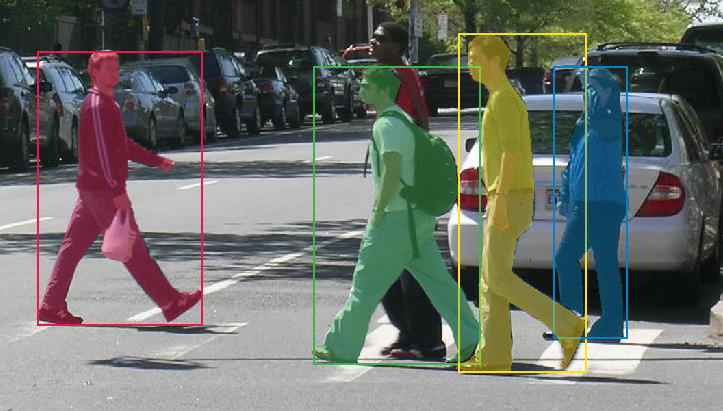

In [134]:
from torchvision.utils import draw_segmentation_masks as dsm
vtf.to_pil_image(dsm(imgs[0],tgs[0]['masks'].to(torch.bool),alpha=0.4,colors=distinct_rgb ) )

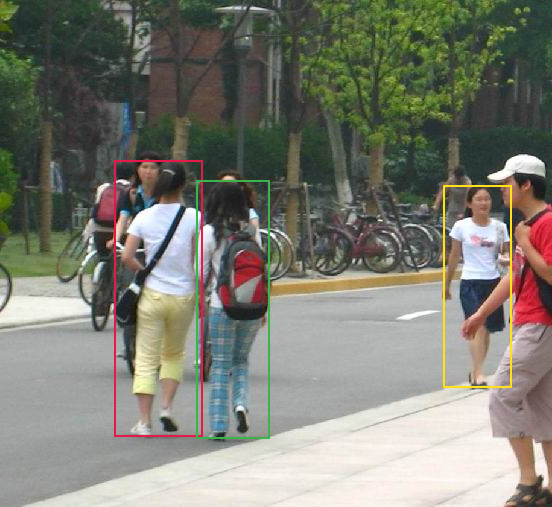

In [67]:
distinct_rgb = [(230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60), (250, 190, 212), (0, 128, 128), (220, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (255, 255, 255), (0, 0, 0)]

from torchvision.utils import draw_bounding_boxes as dbb
from matplotlib import pyplot as plt
i = 3
vtf.to_pil_image(dbb(vtf.pil_to_tensor(vtf.to_pil_image(imgs[i])),tgs[i]['boxes'],width=2,colors=distinct_rgb) ) 

In [43]:
def max_by_axis( the_list):
    # type: (List[List[int]]) -> List[int]
    maxes = the_list[0]
    for sublist in the_list[1:]:
        for index, item in enumerate(sublist):
            maxes[index] = max(maxes[index], item)
    return maxes

In [75]:
def batch_images(images):
    # type: (List[Tensor], int) -> Tensor

    max_size = max_by_axis([list(img.shape) for img in images])
    batch_shape = [len(images)] + max_size
    batched_imgs = images[0].new_full(batch_shape, 0)
    for img, pad_img in zip(images, batched_imgs):
        pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)

    return batched_imgs

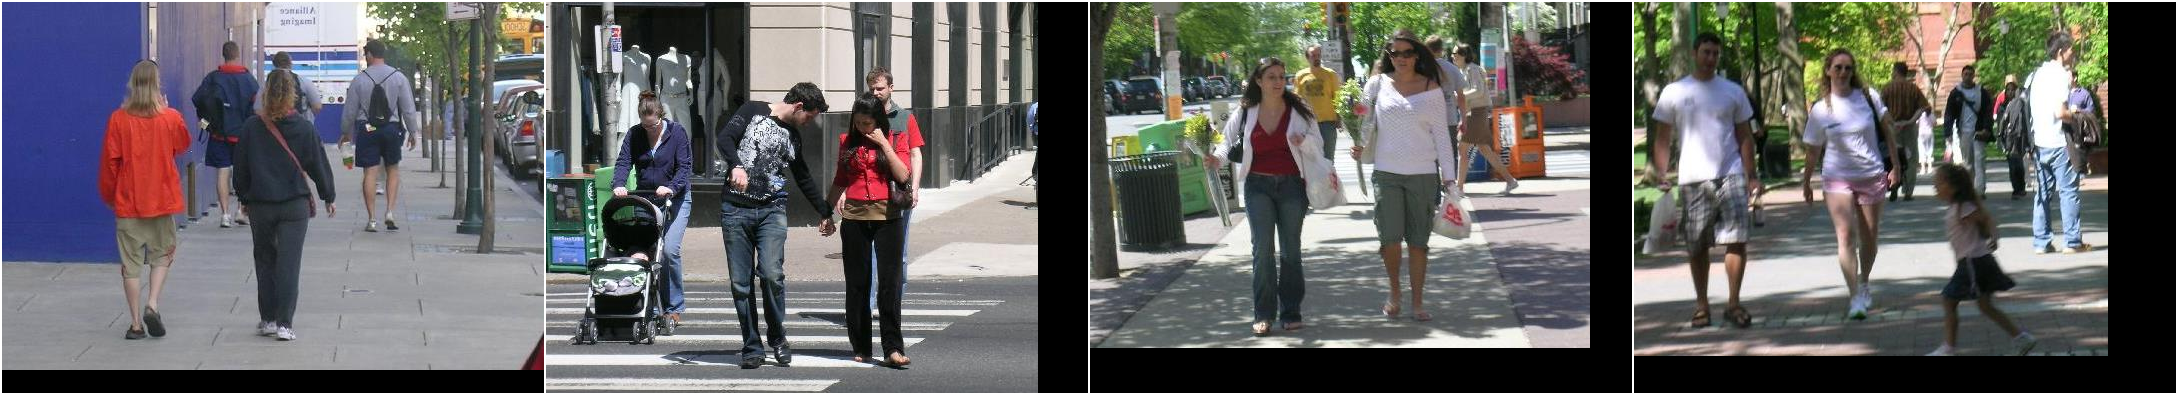

In [106]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

F.to_pil_image(make_grid(batch_images(imgs),pad_value=1 ))